In [14]:
import numpy as np 
import pandas as pd 
from evds import evdsAPI
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings



In [3]:
warnings.filterwarnings("ignore")

In [4]:
evds = evdsAPI("*********")

In [5]:
df = evds.get_data(["TP.DK.USD.A.YTL"], startdate="01-01-2020", enddate="20-08-2024", frequency=3)

In [7]:
df = df.drop("YEARWEEK",axis=1)
df.head(15)

,Tarih,TP_DK_USD_A_YTL
0,03-01-2020,5.94125
1,10-01-2020,5.94520
2,17-01-2020,5.87128
3,24-01-2020,5.90358
4,31-01-2020,5.94228
5,07-02-2020,5.97476
6,14-02-2020,6.01344
7,21-02-2020,6.05608
8,28-02-2020,6.13360
9,06-03-2020,6.16140


In [9]:
df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d-%m-%Y')
df = df.sort_values(by='Tarih')
df.head(10)

,Tarih,TP_DK_USD_A_YTL
0,2020-01-03,5.94125
1,2020-01-10,5.94520
2,2020-01-17,5.87128
3,2020-01-24,5.90358
4,2020-01-31,5.94228
5,2020-02-07,5.97476
6,2020-02-14,6.01344
7,2020-02-21,6.05608
8,2020-02-28,6.13360
9,2020-03-06,6.16140


In [10]:
df.set_index("Tarih", inplace=True)

In [11]:
df.head()

,TP_DK_USD_A_YTL
Tarih,
2020-01-03,5.94125
2020-01-10,5.94520
2020-01-17,5.87128
2020-01-24,5.90358
2020-01-31,5.94228


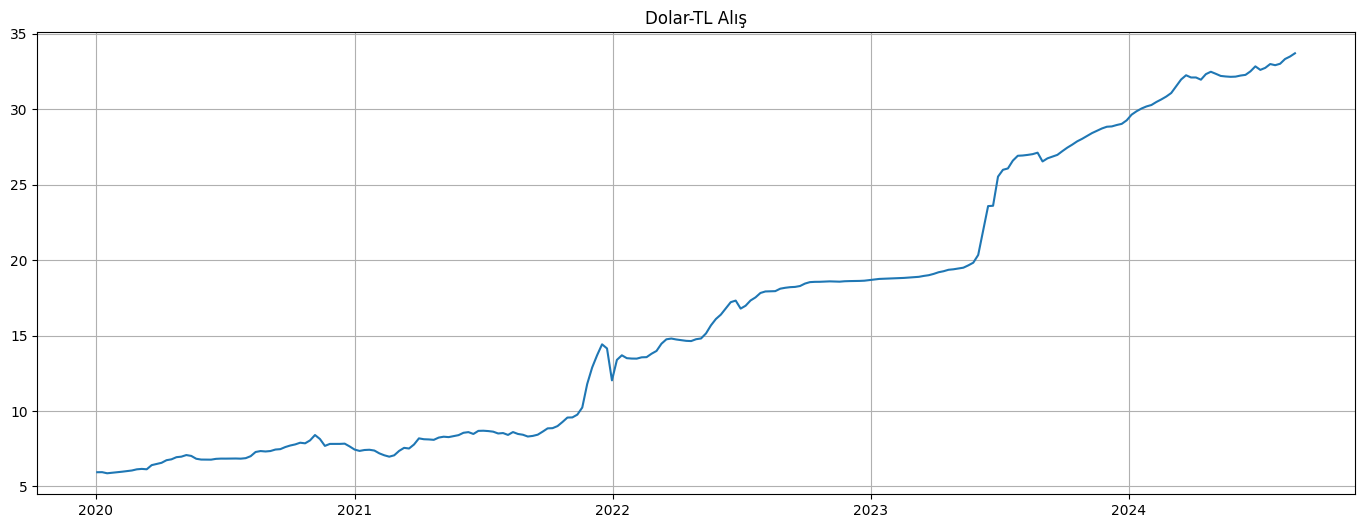

In [12]:
plt.figure(figsize=(17, 6))

plt.plot(df)

plt.title('Dolar-TL Alış')
plt.grid(True)
plt.show()


In [13]:
result = adfuller(df["TP_DK_USD_A_YTL"])

adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print('Critical Values',result[4])


ADF Statistic: 0.7410023625427349
p-value: 0.9906216067978815
Critical Values {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}


In [15]:
df['Differenced_Data'] = df["TP_DK_USD_A_YTL"].diff()
df = df.dropna() 
df.head()

,TP_DK_USD_A_YTL,Differenced_Data
Tarih,,
2020-01-10,5.94520,0.00395
2020-01-17,5.87128,-0.07392
2020-01-24,5.90358,0.03230
2020-01-31,5.94228,0.03870
2020-02-07,5.97476,0.03248


In [16]:
result_differenced = adfuller(df["Differenced_Data"])

adf_statistic = result_differenced[0]
p_value = result_differenced[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print('Critical Values',result_differenced[4])


ADF Statistic: -6.321270713653555
p-value: 3.0619543693185614e-08
Critical Values {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}


<Figure size 1400x600 with 0 Axes>

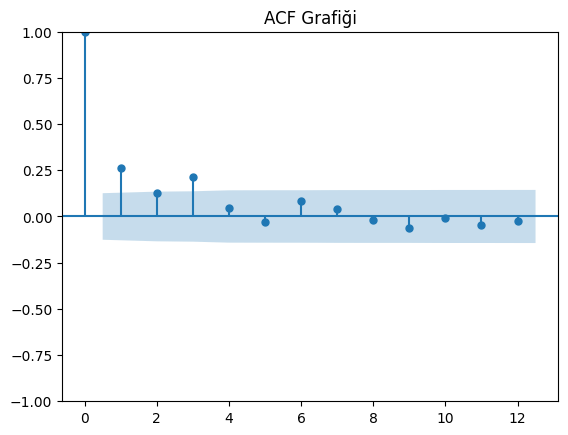

In [17]:
# ACF 
plt.figure(figsize=(14, 6))
plot_acf(df["Differenced_Data"], lags=12)
plt.title('ACF Grafiği')
plt.show()

<Figure size 1200x600 with 0 Axes>

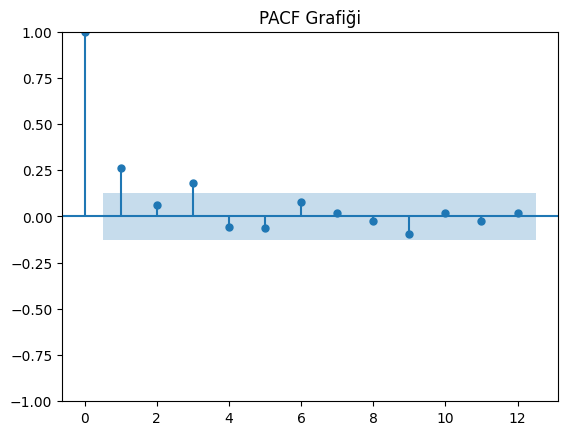

In [18]:
# PACF 
plt.figure(figsize=(12, 6))
plot_pacf(df["Differenced_Data"], lags=12, method='ywm')
plt.title('PACF Grafiği')
plt.show()


In [19]:
split_index = int(0.9 * len(df))
df_train = df["TP_DK_USD_A_YTL"].iloc[:split_index]
df_test = df["TP_DK_USD_A_YTL"].iloc[split_index:]


In [23]:
model = SARIMAX(df_train, 
                order=(1, 1, 11),  
                seasonal_order=(0, 1, 1,30),  
                enforce_stationarity=False, 
                enforce_invertibility=False)


In [24]:
model_fit = model.fit(disp=False)


In [25]:
forecast = model_fit.get_forecast(steps=len(df_test))
predictions = forecast.predicted_mean

In [27]:
mse = mean_squared_error(df_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0495340005001686


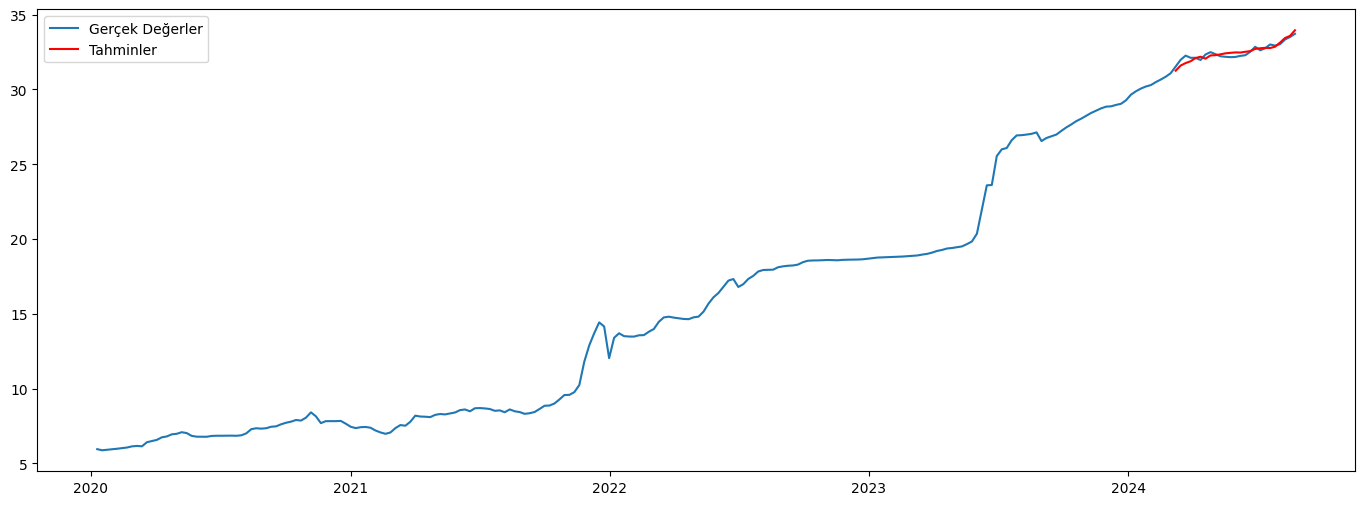

In [29]:
plt.figure(figsize=(17, 6))
plt.plot(df.index, df['TP_DK_USD_A_YTL'], label='Gerçek Değerler')
plt.plot(predictions.index, predictions, label='Tahminler', color='red')
plt.legend()
plt.show()

In [30]:
future_forecast = model_fit.get_forecast(steps=50)
future_predictions = future_forecast.predicted_mean

In [31]:
future_predictions[-30:-5]

2024-07-26    32.852778
2024-08-02    33.126160
2024-08-09    33.433311
2024-08-16    33.575337
2024-08-23    33.950295
2024-08-30    34.095564
2024-09-06    34.289530
2024-09-13    34.549685
2024-09-20    34.680151
2024-09-27    34.808201
2024-10-04    34.989611
2024-10-11    35.317518
2024-10-18    35.461891
2024-10-25    35.564172
2024-11-01    35.781391
2024-11-08    35.844691
2024-11-15    35.703732
2024-11-22    35.925527
2024-11-29    35.945271
2024-12-06    36.008797
2024-12-13    36.081984
2024-12-20    36.114841
2024-12-27    36.145336
2025-01-03    36.135796
2025-01-10    36.185373
Freq: W-FRI, Name: predicted_mean, dtype: float64

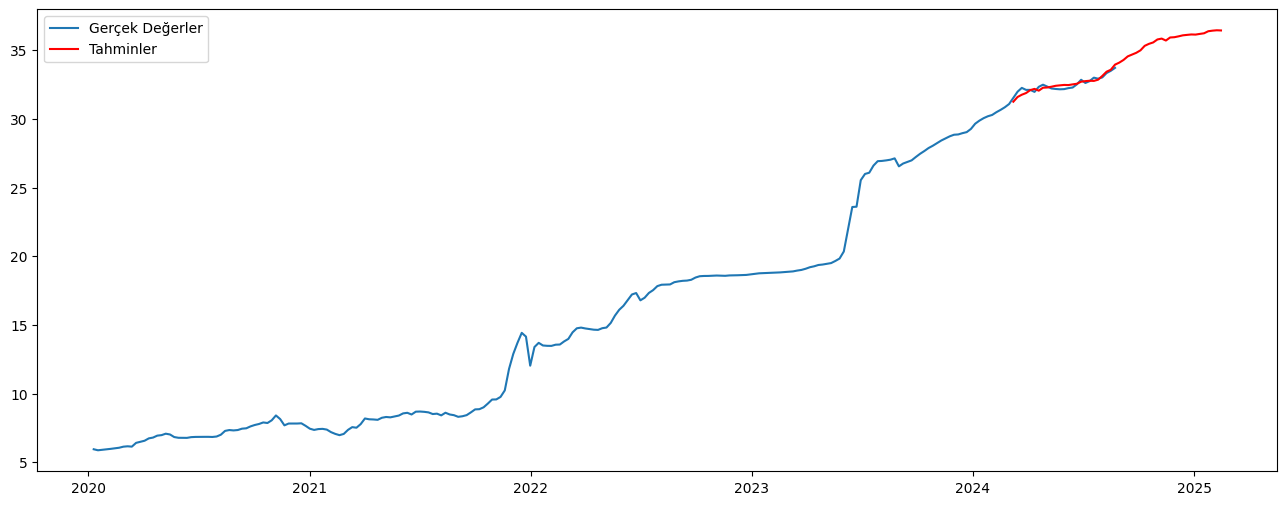

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['TP_DK_USD_A_YTL'], label='Gerçek Değerler')
plt.plot(future_predictions.index, future_predictions, label='Tahminler', color='red')
plt.legend()
plt.show()